In [1]:
from datasets import load_from_disk


In [3]:
dataset=load_from_disk('/shared/how2_all.dataset').with_format('torch')

In [32]:
dataset[392]['vid'].shape

torch.Size([2048])

In [45]:
# Train string encoders
en_data = [" ".join(x) for x in dataset['en']]
pt_data = [" ".join(x) for x in dataset['pt']]
sm_data = [" ".join(x) for x in dataset['sm'] if x]

In [59]:
#en_training_corpus = (
#    en_data[i : i + 1000]
#    for i in range(0, len(en_data), 1000)
#)

In [48]:
from transformers import AutoTokenizer

#old_tokenizer = AutoTokenizer.from_pretrained("gpt2")
#old_tokenizer.encode(" ".join(dataset[0]['sm']))

In [146]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()

trainer = BpeTrainer(special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"],
                    vocab_size=8192)

In [117]:
tokenizer.train_from_iterator(sm_data,trainer)

In [118]:
tokenizer.save('sm_tokenizer')

In [119]:
tokenizer.get_vocab_size()
tokenizer.get_vocab()

{'apped': 7302,
 'calves': 7902,
 'robe': 4426,
 'crystal': 4703,
 'fant': 5226,
 'fortune': 4575,
 'loveall': 5919,
 'birdcage': 6483,
 'beats': 2749,
 'spread': 4128,
 'bear': 1835,
 'testing': 4828,
 'suffering': 7187,
 'outdoorsman': 7229,
 'therap': 758,
 'mouse': 4207,
 'nicely': 7917,
 'carpenter': 4389,
 'feren': 3278,
 'exer': 245,
 'cir': 1033,
 'things': 2047,
 'mechan': 1241,
 'colepsy': 7348,
 'shelter': 7977,
 'angelo': 8171,
 'shine': 4412,
 'pod': 2066,
 'leading': 4344,
 'dynam': 5716,
 'apples': 6407,
 'orchid': 7346,
 'equine': 3059,
 'instructor': 258,
 'noseblunt': 7573,
 'cu': 462,
 'eliminate': 4377,
 'word': 1586,
 'ics': 604,
 'comers': 7845,
 'rate': 4108,
 'nurse': 4030,
 'sound': 1458,
 'swee': 6844,
 'intervie': 3008,
 'garlic': 2293,
 'planets': 7790,
 'stands': 6477,
 'scheduling': 3628,
 'bloo': 5217,
 'wondering': 7969,
 'antiques': 3730,
 'ank': 1342,
 'cy': 537,
 'peanut': 4727,
 'cages': 5944,
 'editor': 3481,
 'listening': 3779,
 'promin': 7864,
 'i

In [152]:
sm_tokenizer.encode(sm_data[23])
#sm_data

[67,
 2769,
 616,
 119,
 438,
 305,
 594,
 13,
 6248,
 12,
 727,
 58,
 73,
 5224,
 83,
 7120,
 99,
 119,
 1821,
 136,
 421,
 119,
 1117,
 14,
 1728,
 305,
 594,
 13,
 6248,
 202,
 342,
 186,
 5287,
 1187,
 9,
 48,
 5890,
 93,
 102,
 92,
 30,
 1371,
 3584,
 58,
 76,
 77,
 80,
 63,
 594,
 13,
 397,
 14]

In [150]:
from transformers import PreTrainedTokenizerFast
sm_tokenizer = PreTrainedTokenizerFast(tokenizer_file="sm_tokenizer")
en_tokenizer = PreTrainedTokenizerFast(tokenizer_file="en_tokenizer")
pt_tokenizer = PreTrainedTokenizerFast(tokenizer_file="pt_tokenizer")

In [155]:
import torch
def dataset_reorg(batch):
    data_dict = {
        'vid': {'indices': torch.arange(1,len(batch['vid'])+1),
                'values': batch['vid']},
        'aud': {'values': batch['aud']},
        'en': {'tokens': en_tokenizer.encode(" ".join(batch['en']))},
        'pt': {'tokens': pt_tokenizer.encode(" ".join(batch['pt']))},
        'sm': {'tokens': sm_tokenizer.encode(" ".join(batch['sm']) if batch['sm'] else "")}
    }
    return data_dict


In [271]:
def hotfix(batch):
    batch['vid']['indices'] = batch['vid']['indices'] + 1
    return(batch)

In [273]:
#dataset = dataset.map(dataset_reorg)
dataset = dataset.map(hotfix, num_proc=16)

Map (num_proc=16):   0%|          | 0/184949 [00:00<?, ? examples/s]

In [160]:
dataset.save_to_disk('/shared/how2_all_proc')

Saving the dataset (0/42 shards):   0%|          | 0/184949 [00:00<?, ? examples/s]

In [226]:
dataset = load_from_disk('/shared/how2_all_proc')

In [227]:
import os, sys
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('.'))))

In [571]:
from encoders import MultimodalCollator
import importlib
importlib.reload(encoders)

<module 'encoders' from '/efs-private/multimodal/encoders.py'>

In [553]:
modality_config = {'aud':{'type':'matrix','pad_len':2048, 'max_channels':40},
                   'en':{'type':'sequence','pad_len':256, 'data_col_name':"tokens"},
                   'pt':{'type':'sequence','pad_len':256, 'data_col_name':"tokens"},
                   'sm':{'type':'sequence','pad_len':128, 'data_col_name':"tokens"},
                   'vid':{'type':'sequence','pad_len':2048},
                  }

In [554]:
mc = MultimodalCollator(modality_config)

In [555]:
mc.modality_collators.keys()
#sample = dataset[0]
#sample.pop('name',None)
#sample.keys()

dict_keys(['aud', 'en', 'pt', 'sm', 'vid'])

In [457]:
sample = dataset[10:18]
sample.pop('name',None)

['--8pSDeC-fg_1',
 '--8pSDeC-fg_10',
 '--8pSDeC-fg_11',
 '--8pSDeC-fg_12',
 '--8pSDeC-fg_13',
 '--8pSDeC-fg_14',
 '--8pSDeC-fg_15',
 '--8pSDeC-fg_16']

In [458]:
print(sample)
collated = mc(sample)

{'vid': [{'indices': tensor([   1,    2,    3,  ..., 2046, 2047, 2048]), 'values': tensor([0.7105, 0.8883, 0.0125,  ..., 0.2998, 0.1596, 0.1411])}, {'indices': tensor([   1,    2,    3,  ..., 2046, 2047, 2048]), 'values': tensor([0.7105, 0.8883, 0.0125,  ..., 0.2998, 0.1596, 0.1411])}, {'indices': tensor([   1,    2,    3,  ..., 2046, 2047, 2048]), 'values': tensor([0.7105, 0.8883, 0.0125,  ..., 0.2998, 0.1596, 0.1411])}, {'indices': tensor([   1,    2,    3,  ..., 2046, 2047, 2048]), 'values': tensor([0.7105, 0.8883, 0.0125,  ..., 0.2998, 0.1596, 0.1411])}, {'indices': tensor([   1,    2,    3,  ..., 2046, 2047, 2048]), 'values': tensor([0.7105, 0.8883, 0.0125,  ..., 0.2998, 0.1596, 0.1411])}, {'indices': tensor([   1,    2,    3,  ..., 2046, 2047, 2048]), 'values': tensor([0.7105, 0.8883, 0.0125,  ..., 0.2998, 0.1596, 0.1411])}, {'indices': tensor([   1,    2,    3,  ..., 2046, 2047, 2048]), 'values': tensor([0.7105, 0.8883, 0.0125,  ..., 0.2998, 0.1596, 0.1411])}, {'indices': tensor

In [459]:
collated

{'vid': {'indices': tensor([[   1,    2,    3,  ..., 2046, 2047, 2048],
          [   1,    2,    3,  ..., 2046, 2047, 2048],
          [   1,    2,    3,  ..., 2046, 2047, 2048],
          ...,
          [   1,    2,    3,  ..., 2046, 2047, 2048],
          [   1,    2,    3,  ..., 2046, 2047, 2048],
          [   1,    2,    3,  ..., 2046, 2047, 2048]]),
  'attention_mask': tensor([[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]),
  'values': tensor([[0.7105, 0.8883, 0.0125,  ..., 0.2998, 0.1596, 0.1411],
          [0.7105, 0.8883, 0.0125,  ..., 0.2998, 0.1596, 0.1411],
          [0.7105, 0.8883, 0.0125,  ..., 0.2998, 0.1596, 0.1411],
          ...,
          [0.7105, 0.8883, 0.0125,  ..., 0.2998, 0.1596, 0.1411],
          [0.7105, 0.8883, 0.0125,  ..., 0.2998, 0.1596, 0.1411],
          [0.7105, 0.8883, 0.0125, 

In [527]:
from encoders import PatchEncoder

In [528]:
penc=PatchEncoder(max_tokens=320, patch_size = (32,8))

In [529]:
x,at = penc(collated['aud'])

In [530]:
collated['aud']['values'][6,:,:]

tensor([[    14.1159,     16.2858,     15.9622,  ...,     13.2830,
             13.0229,     12.6879],
        [    14.3077,     16.7415,     16.5961,  ...,     13.9218,
             12.8430,     12.2267],
        [    15.1387,     17.2530,     17.0790,  ...,     13.9710,
             13.5673,     12.5957],
        ...,
        [-10000.0000, -10000.0000, -10000.0000,  ..., -10000.0000,
         -10000.0000, -10000.0000],
        [-10000.0000, -10000.0000, -10000.0000,  ..., -10000.0000,
         -10000.0000, -10000.0000],
        [-10000.0000, -10000.0000, -10000.0000,  ..., -10000.0000,
         -10000.0000, -10000.0000]])

In [531]:
batch['aud']['values'][3].shape

torch.Size([449, 43])

In [532]:
collated['aud']['values'].shape

torch.Size([8, 2048, 40])

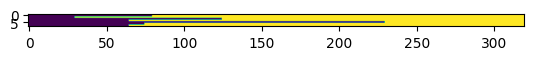

In [533]:
import matplotlib.pyplot as plt
plt.imshow(at)

In [573]:
encoder_configs = {'aud':{'type':'PatchEncoder',
                         'max_tokens':320, 
                         'patch_size':(32,8)},
                   'en':{'type':'SequenceEncoder',
                         'num_embeddings':8192, 
                         'max_tokens':256},
                   'pt':{'type':'SequenceEncoder',
                         'num_embeddings':8192, 
                         'max_tokens':256},
                   'sm':{'type':'SequenceEncoder',
                         'num_embeddings':8192, 
                         'max_tokens':256},
                   'vid':{'type':'TabularEncoder',
                          "num_embeddings":2048,
                         },
                  }

In [574]:
from encoders import encoders_dict
encoder_classes = {modality_name: encoders_dict[encoder_config['type']](**encoder_config)
                         for modality_name, encoder_config in encoder_configs.items()}

In [545]:
encoder_classes = None

In [575]:
token_types = list(collated.keys())
tokens, attention_masks = zip(*[encoder_classes[modality_name](collated[modality_name])
                   for modality_name in token_types])

In [576]:
token_types

['vid', 'en', 'pt', 'sm', 'aud']

In [579]:
tokens[0].shape

torch.Size([8, 2048, 512])